In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from src.tools import MMSeqs
from src.tools.mmseqs import alignment_to_csr_matrix
from src.clusterer import Clusterer
from tqdm import tqdm
from scipy.sparse import load_npz
from src.files import InterProScanFile
import itertools
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [ ]:
dataset_df = pd.read_csv('../data/datasets/dataset.csv', index_col=0)
cluster_df = pd.read_csv('../data/datasets/dataset_cluster.csv', index_col=0)
dataset_df = dataset_df.merg
clusterer = Clusterer.load('../data/datasets/dataset_cluster.pkl')
idxs = idxs = {id_:idx for idx, id_ in enumerate(dataset_df.index)}

spurious_cluster_ids = cluster_df[dataset_df.label == 0].cluster_id.unique()
real_cluster_ids = cluster_df[dataset_df.label == 1].cluster_id.unique()

In [6]:
# matrix = alignment_to_csr_matrix('../data/datasets/dataset_dataset_align.tsv', index=dataset_df.index.values, chunk_size=50000)
matrix = load_npz('../data/datasets/dataset_dataset_align.npz')

In [7]:
cluster_metadata_df = pd.DataFrame(index=pd.Index(np.arange(clusterer.n_clusters), name='cluster_id'))
cluster_metadata_df['cluster_size'] = cluster_df.groupby('cluster_id').apply(len, include_groups=False)

In [ ]:
# Would be good to get a sense of the taxonomic composition of the clusters at different levels. 
def figure(cluster_df)

70

In [ ]:
def get_cluster_sequence_identities(cluster_id:int):
    cluster_idxs = clusterer.cluster_idxs[cluster_id]
    if len(cluster_idxs) == 1:
        return 0

    sequence_identities = list()
    for i, j in itertools.combinations(cluster_idxs, 2):
        sequence_identities.append(matrix[i, j])
    sequence_identities = np.array(sequence_identities)
    return sequence_identities

In [ ]:
def add_align_metadata(path:str='../data/datasets/dataset_cluster_metadata.csv'):

    cluster_metadata_df = list()
    for cluster_id in tqdm(np.arange(clusterer.n_clusters), 'add_align_metadata: Computing alignment data for each cluster.'):
        sequence_identities = get_cluster_sequence_identities(cluster_id)

        row = {'cluster_id':cluster_id}
        if sequence_identities is not None:
            row['n_aligned'] = (sequence_identities > 0).sum()
            row['frac_aligned'] = row['n_aligned'] / len(sequence_identities) # Fraction of possible alignments which were made. 
            sequence_identities = sequence_identities[sequence_identities > 0]
            row['mean_sequence_identity'] = sequence_identities.mean() if (row['n_aligned'] > 0) else 0
            row['min_sequence_identity'] = sequence_identities.min() if (row['n_aligned'] > 0) else 0
            row['max_sequence_identity'] = sequence_identities.max() if (row['n_aligned'] > 0) else 0

        cluster_metadata_df.append(row)

    cluster_metadata_df = pd.DataFrame(cluster_metadata_df).set_index('cluster_id')

    cluster_metadata_df_ = pd.read_csv(path, index_col=0)
    cluster_metadata_df_ = cluster_metadata_df_.drop(columns=cluster_metadata_df.columns, errors='ignore')

    cluster_metadata_df = cluster_metadata_df.merge(cluster_metadata_df_, left_index=True, right_index=True, validate='one_to_one')
    print(f'add_align_metadata: Adding alignment metadata to the cluster metadata file {path}')
    cluster_metadata_df.to_csv(path)

In [109]:
cluster_metadata_df = pd.read_csv('../data/datasets/dataset_cluster_metadata.csv', index_col=0)

In [111]:
cluster_metadata_df.columns

Index(['n_aligned', 'frac_aligned', 'mean_sequence_identity',
       'min_sequence_identity', 'max_sequence_identity', 'cluster_size',
       'cluster_label', 'cluster_radius', 'intra_cluster_max_distance',
       'intra_cluster_min_distance', 'intra_cluster_mean_distance',
       'inter_cluster_max_distance', 'inter_cluster_min_distance',
       'inter_cluster_mean_distance'],
      dtype='object')

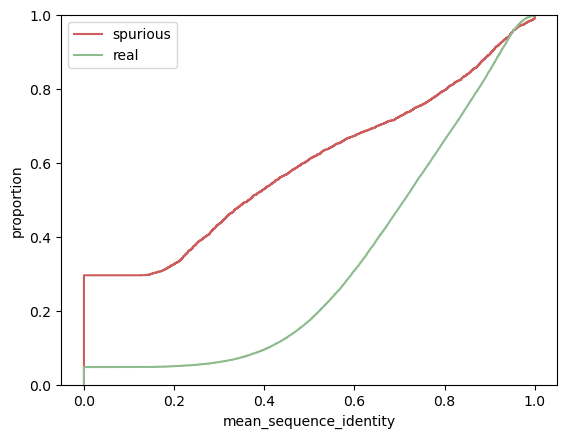

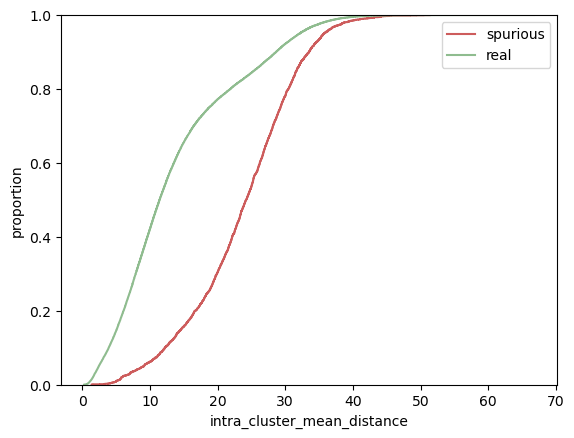

In [128]:
def figure(cluster_metadata_df:pd.DataFrame, metric:str='mean_sequence_identity', drop_singletons:bool=True, spurious_cluster_ids=spurious_cluster_ids, real_cluster_ids=real_cluster_ids):

    fig, ax = plt.subplots()

    scale = lambda series : (series - series.min()) / series.max()

    if drop_singletons:
        cluster_metadata_df = cluster_metadata_df[~cluster_metadata_df.n_aligned.isnull()]
        spurious_cluster_ids = spurious_cluster_ids[np.isin(spurious_cluster_ids, cluster_metadata_df.index)]
        real_cluster_ids = real_cluster_ids[np.isin(real_cluster_ids, cluster_metadata_df.index)]
        
    ax_df = cluster_metadata_df[['mean_sequence_identity', 'intra_cluster_mean_distance', 'frac_aligned']].copy()
    # ax_df['mean_sequence_identity'] = scale(ax_df.mean_sequence_identity * ax_df.frac_aligned)
    # ax_df['intra_cluster_mean_distance'] = 1 - scale(ax_df.intra_cluster_mean_distance)
    sns.ecdfplot(data=ax_df.loc[spurious_cluster_ids], x=metric, ax=ax, color='indianred', label='spurious')
    sns.ecdfplot(data=ax_df.loc[real_cluster_ids], x=metric, ax=ax, color='darkseagreen', label='real')
    # sns.ecdfplot(data=ax_df.loc[spurious_cluster_ids], x='intra_cluster_mean_distance', ax=ax, color='indianred', label='spurious', linestyle=':')
    # sns.ecdfplot(data=ax_df.loc[real_cluster_ids], x='intra_cluster_mean_distance', ax=ax, color='darkseagreen', label='real', linestyle=':')
    ax.legend()
    ax.set_ylabel('proportion')
    plt.show()

figure(cluster_metadata_df)
figure(cluster_metadata_df, metric='intra_cluster_mean_distance')


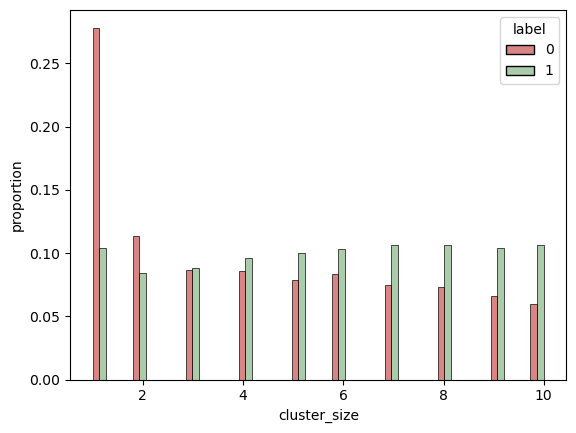

In [99]:
def figure(cluster_metadata_df:pd.DataFrame):
    fig, ax = plt.subplots()

    ax_df = cluster_metadata_df[['cluster_size']].copy()
    ax_df['label'] = 1
    ax_df.loc[spurious_cluster_ids, 'label'] = 0 

    palette = {0:'indianred', 1:'darkseagreen'}
    sns.histplot(data=ax_df, hue='label', ax=ax, palette=palette, x='cluster_size', multiple='dodge', stat='proportion', common_norm=False) # , binwidth=0.5)
    # ax.set_xlim(xmin=1, xmax=11)
    ax.set_ylabel('proportion')

    plt.show()

figure(cluster_metadata_df)

<Axes: xlabel='intra_cluster_mean_distance', ylabel='mean_sequence_identity'>

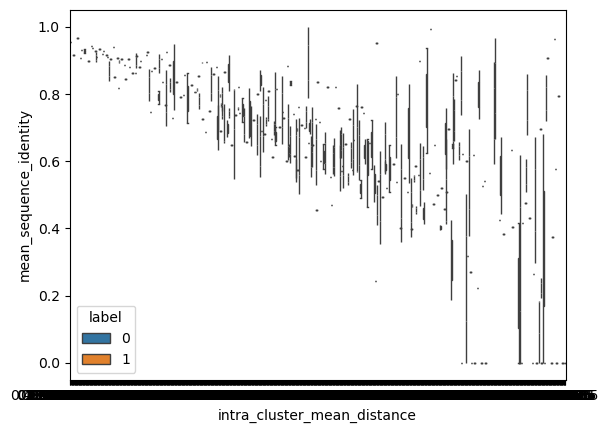

In [ ]:
def figure(cluster_metadata_df)

sns.boxplot(data=cluster_metadata_df[cluster_metadata_df.cluster_size > 1].sample(1000), hue='label', x='intra_cluster_mean_distance', y='mean_sequence_identity')

In [75]:
    # ax_df['all_aligned'] = (cluster_metadata_df.frac_aligned == 1)
    # ax_df['gt_50_aligned'] = (cluster_metadata_df.frac_aligned < 1) & (cluster_metadata_df.frac_aligned > 0.5)
    # ax_df['lt_50_aligned'] = (cluster_metadata_df.frac_aligned > 0) & (cluster_metadata_df.frac_aligned <= 0.5) 
    # ax_df['none_aligned'] = (cluster_metadata_df.frac_aligned == 0) 
    # ax_df['singleton'] = cluster_metadata_df.frac_aligned.isnull()

    # sns.ecdfplot(data=ax_df[ax_df.all_aligned], x='mean_sequence_identity', ax=ax, color='darkseagreen', label=f'all_aligned (n={ax_df.all_aligned.sum()})')
    # sns.ecdfplot(data=ax_df[ax_df.gt_50_aligned], x='mean_sequence_identity', ax=ax, color='burlywood', label=f'gt_50_aligned (n={ax_df.gt_50_aligned.sum()})')
    # sns.ecdfplot(data=ax_df[ax_df.lt_50_aligned], x='mean_sequence_identity', ax=ax, color='indianred', label=f'lt_50_aligned (n={ax_df.lt_50_aligned.sum()})')
    # sns.ecdfplot(data=ax_df[ax_df.none_aligned], x='mean_sequence_identity', ax=ax, color='black', label=f'none_aligned (n={ax_df.none_aligned.sum()})')
    # sns.ecdfplot(data=ax_df[ax_df.singleton].fillna(0), x='mean_sequence_identity', ax=ax, color='gray', label=f'singleton (n={ax_df.singleton.sum()})')
    

In [ ]:
# First want to characterize the spurious clusters. 
spurious_ids = dataset_df[dataset_df.label == 0].index
spurious_cluster_ids = cluster_df.loc[spurious_ids].cluster_id.unique()

annotations_df = InterProScanFile('../data/interpro/antifam_bacteria_annotation.tsv').to_df(add_prefix=False)
annotations_df = annotations_df[annotations_df.index.isin(spurious_ids) & (annotations_df.analysis == 'AntiFam')]

antifam_ids = dict()
for id_, df in annotations_df.groupby(annotations_df.index):
    antifam_ids[id_] = list(df.signature.unique())

In [18]:
cluster_antifam_ids = dict()
for cluster_id, df in cluster_df.loc[spurious_ids].groupby('cluster_id'):
    info = dict()
    info['antifam_ids'] = set([antifam_id for id_ in df.index for antifam_id in antifam_ids[id_]])
    info['size'] = len(df)
    cluster_antifam_ids[cluster_id] = info

In [20]:
(cluster_df.loc[spurious_ids].groupby('cluster_id').apply(len, include_groups=False) == 1).sum()

np.int64(1115)

In [21]:
(np.array([len(info['antifam_ids']) for info in cluster_antifam_ids.values()]) == 1).sum()

np.int64(2018)

In [23]:
len(cluster_antifam_ids)

4006

In [ ]:
# What fraction of alignments between sequences in a cluster were made? There are (n choose 2) possible alignments. 
# How do the in-cluster alignments compare to the out-of-cluster alignments?
cluster_df[cluster_df.cluster_id == 0]


,cluster_id
id,
A0A1R1S6L4,0
A0A1V6DLB4,0
A0A1V6E088,0
A0A1V6E588,0
A0A1V6E6X7,0
A0AAE6G6K0,0
M3B7X1,0


In [24]:
cluster_metadata_df = pd.read_csv('../data/datasets/dataset_cluster_metadata.csv', index_col=0)

In [25]:
cluster_metadata_df

,cluster_size,cluster_label,cluster_radius,intra_cluster_max_distance,intra_cluster_min_distance,intra_cluster_mean_distance,inter_cluster_max_distance,inter_cluster_min_distance,inter_cluster_mean_distance
cluster_id,,,,,,,,,
0,7,0,30.000000,53.531250,22.656250,37.343750,130.90,27.840,87.20
1,8,1,16.843750,26.046875,9.640625,18.312500,125.30,12.880,54.03
2,8,1,30.031250,47.593750,10.289062,34.156250,125.60,16.770,52.34
3,8,1,26.000000,35.812500,4.839844,21.781250,122.75,16.840,47.40
4,2,1,5.613281,11.226562,11.226562,11.226562,130.40,14.290,54.90
...,...,...,...,...,...,...,...,...,...
49995,8,1,2.255859,3.699219,0.837402,2.150391,122.75,2.195,42.12
49996,6,1,12.812500,20.796875,9.734375,16.921875,125.00,20.300,44.22
49997,6,1,4.269531,6.042969,0.613770,4.023438,122.30,4.566,41.62
